In [77]:
import os
import torch
import numpy as np
import albumentations as A 
import matplotlib.pyplot as plt 
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from PIL import Image,ImageDraw,ImageFont
from torchvision.datasets import ImageFolder
from albumentations.pytorch import ToTensorV2

Constants

In [59]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

TRAIN_PATH = './Data/Training'
TEST_PATH = './Data/Testing'
BATCH_SIZE = 16
IMG_SIZE = (244,244)

i2c = {
    0:'glioma',
    1:'meningioma',
    2:'notumor',
    3:'pituitary'
}
c2i = {v:k for k,v in i2c.items()}

In [30]:
def tag(img,y,pred):
    resized = img.resize(IMG_SIZE).convert('RGB')
    draw = ImageDraw.Draw(resized)

    font = ImageFont.truetype('./Exo-Bold.otf',15)
    bbox_color = (0,255,0)
    if y!=pred:
        bbox_color = (255,0,0)
    
    bbox_padd = 4
    text_point = (15,10)
    
    bbox = draw.textbbox(text_point,i2c[pred],font=font)
    padded_box = (
        bbox[0]-bbox_padd,
        bbox[1]-bbox_padd,
        bbox[2]+bbox_padd,
        bbox[3]+bbox_padd
    )
    
    draw.rectangle(padded_box,outline=bbox_color)
    draw.text(text_point,i2c[pred],font=font)
    return resized

In [31]:
def show_samples(imgs,y=None,pred=None):
    cols = 3
    rows = int(np.ceil(imgs.shape[0]/cols))
    padd = 15
    width =  (IMG_SIZE[0] + padd) * cols
    height = (IMG_SIZE[1] + padd) * rows
    grid = Image.new('RGB',(width,height))
    
    
    col_counter = 0
    left = padd
    top = padd
    for i in range(imgs.shape[0]):
        
        img = Image.fromarray(imgs[i]).resize(IMG_SIZE)
        if y and pred:
            img = tag(img,y[i],pred[i])
                
        if col_counter==cols:
            col_counter = 0 
            left = 0
            top += (IMG_SIZE[1] + padd)
        
        grid.paste(img,(left,top))
        
        left += (IMG_SIZE[0] + padd)
        col_counter += 1
        
    return grid

In [48]:
def rand_samples(num=9):
    folders = os.listdir(TRAIN_PATH)
    imgs = []
    targets = []
    for n in range(num):
        folder = np.random.choice(folders)
        name = np.random.choice(os.listdir(f'{TRAIN_PATH}/{folder}'))
        img = Image.open(f'{TRAIN_PATH}/{folder}/{name}').resize(IMG_SIZE)
        imgs.append(img)
        targets.append(c2i[folder])
        
    return show_samples(np.array(imgs),targets,targets)

Data understanding

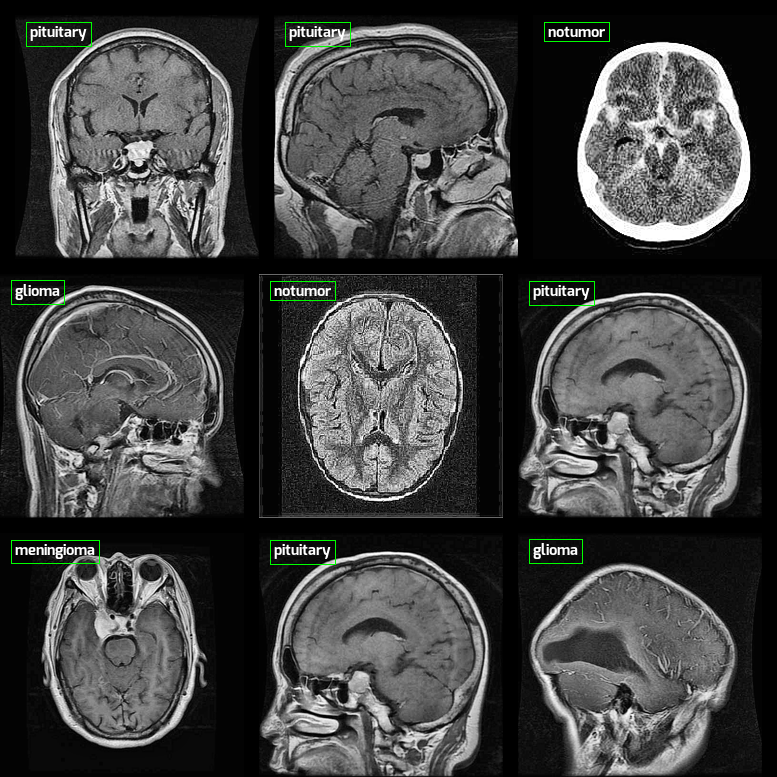

In [51]:
# Random samples from training folder
rand_samples(9)

{'glioma': 1321, 'meningioma': 1339, 'notumor': 1595, 'pituitary': 1457}


<BarContainer object of 4 artists>

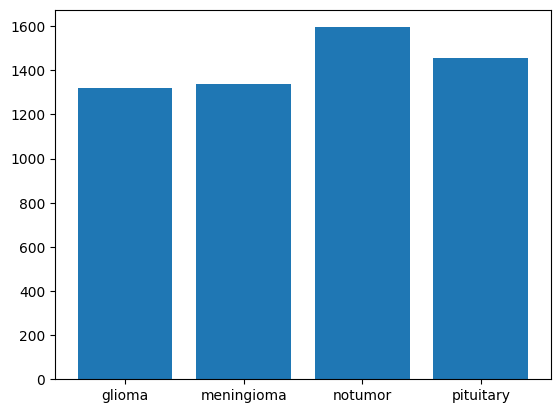

In [57]:
# Destribution of data
des = {i:len(os.listdir(os.path.join(TRAIN_PATH,i))) for i in os.listdir(TRAIN_PATH)}
print(des)
plt.bar(des.keys(),des.values())

Loading & Preparing data

In [83]:
transform = A.Compose([
    A.Resize(IMG_SIZE[0],IMG_SIZE[1]),
    A.Normalize(),
    ToTensorV2()
])

eval_transform = A.Compose([
    A.Resize(IMG_SIZE[0],IMG_SIZE[1]),
    A.Normalize(),
    ToTensorV2()
])

In [84]:
totalset = ImageFolder(TRAIN_PATH,transform)
train_size = int(.8 *len(totalset))
val_size = len(totalset) - train_size

trainset,valset = random_split(totalset,[train_size,val_size])
testset = ImageFolder(TEST_PATH,eval_transform)

valset.dataset.transform = eval_transform
print(f'Train size: {train_size}\nValidation size: {val_size}\nTest size: {len(testset)}')

Train size: 4569
Validation size: 1143
Test size: 1311


In [89]:
train_loader = DataLoader(trainset,BATCH_SIZE,num_workers=2)
test_loader = DataLoader(testset,len(testset),num_workers=2)
val_loader = DataLoader(valset,len(valset),num_workers=2)